## Data from sediment 
In this notebook we will focus on 2 class classification based on enviromental supplementation.

In [1]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Sed/sed_bacteria_full_feature_table.csv')
df.head()



,pond,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sed_S10,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sed_S11,81.0,21.0,29.0,90.0,NaN,8.0,10.0,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sed_S11,3.0,13.0,18.0,3.0,NaN,3.0,18.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sed_S12,171.0,67.0,109.0,76.0,23.0,31.0,NaN,1.0,352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
predictors = df.columns[1:]
len(predictors)

227

In [4]:
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"class_timepoint",  classes)

In [5]:
df.fillna(0, inplace=True)
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,87.880000,88.440000,238.540000,60.020000,13.140000,14.420000,17.660000,7.420000,103.480000,...,0.440000,0.720000,0.460000,0.30000,0.900000,0.260000,0.240000,0.220000,0.220000,0.200000
std,0.505076,72.437909,65.694767,359.278484,40.221068,21.783733,21.364753,24.860927,11.510581,127.867636,...,2.214608,4.549232,3.252691,2.12132,4.704535,1.838478,1.697056,1.555635,1.555635,1.414214
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,34.500000,24.000000,33.250000,0.000000,0.000000,0.000000,0.000000,3.250000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,82.000000,73.500000,88.500000,56.500000,4.000000,2.000000,6.000000,1.500000,51.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,126.250000,121.000000,297.000000,80.000000,19.500000,22.000000,28.000000,10.000000,196.750000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,368.000000,256.000000,1898.000000,170.000000,103.000000,86.000000,113.000000,52.000000,463.000000,...,13.000000,32.000000,23.000000,15.00000,30.000000,13.000000,12.000000,11.000000,11.000000,10.000000


In [6]:
# for normalisation we will use starndard min-max normalisation
df[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)


In [7]:
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,0.238804,0.345469,0.125680,0.353059,0.127573,0.167674,0.156283,0.142692,0.223499,...,0.033846,0.022500,0.020000,0.020000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000
std,0.505076,0.196842,0.256620,0.189293,0.236595,0.211493,0.248427,0.220008,0.221357,0.276172,...,0.170354,0.142163,0.141421,0.141421,0.156818,0.141421,0.141421,0.141421,0.141421,0.141421
min,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.086957,0.134766,0.012645,0.195588,0.000000,0.000000,0.000000,0.000000,0.007019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.222826,0.287109,0.046628,0.332353,0.038835,0.023256,0.053097,0.028846,0.110151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.343071,0.472656,0.156481,0.470588,0.189320,0.255814,0.247788,0.192308,0.424946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In this approach we will use 3 class classification based only on water supplementation 
Those classes will be: No supplementation, Em farma, EM

| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [8]:
# function for decoding pond number
def pond_decoder(x,codes):
    
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

In [9]:
# function for reseting model weights
def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))


In [10]:
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32], 2 : [9,13,17,20,27,11,15,22,25,31]}

df['pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))

In [11]:
pondXtime = df['pond'].astype(str) + "_" + df['class_timepoint'].astype(str)
df.insert(1,"pondXtime", pondXtime)

C:\Users\marek\AppData\Local\Temp\ipykernel_23236\1706034138.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1,"pondXtime", pondXtime)


In [12]:
df.head()
df['pondXtime'].value_counts()

pondXtime
1_0    10
1_1    10
2_0    10
2_1    10
0_0     5
0_1     5
Name: count, dtype: int64

We will create test dataset wchich will be used to test model after crossvalidating each approach

In [13]:
train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
print(train_val_df.shape, test_df.shape)

(40, 230) (10, 230)


For crossvalidation purposes we will create 4 subsets of size 10 each, 3 of them will be used as train dataset and one as validating dataset.  This then will be repeated 4 times and validation result will be mean of results.

In [109]:
kf = KFold(n_splits=4, shuffle=True, random_state=111)


### Modeling differences between Classes for both timepoints at the same time

In [46]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
#model2.add(keras.layers.Dense(128, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(3, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,803 (151.57 KB)

 Trainable params: 38,803 (151.57 KB)

 Non-trainable params: 0 (0.00 B)

None


In [47]:
# early stopping callback to save the best model weights
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=20,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

Here in one loop we will iterate over all datasets train and validate for each of them and gather results. Using corssvalidation. We will also introduce for debugging purposes, confidence score metric. It is calculated for each predicted label from validation/test dataset. As we probably know output from softmax layer is vector of probabilitis of belonging to each clas 

training for 1 subset
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 1.1001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 0 1 1 1 1 1 2 0 1]
true validation classes: [1 1 2 2 2 1 1 0 0 1]
mean confidence score: 0.0698, sd confidence score: 0.0436
training for 2 subset
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3000 - loss: 1.1163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predicted classes:       [2 2 1 0 2 0 1 1 0 1]
true validation classes: [2 0 2 0 2 2 2 2 1 2]
mean confidence score: 0.0692, sd confidence score: 0.0664
training for 3 subset
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4000 - loss: 1.0937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [1 1 1 0 0 1 1 0 1 1]

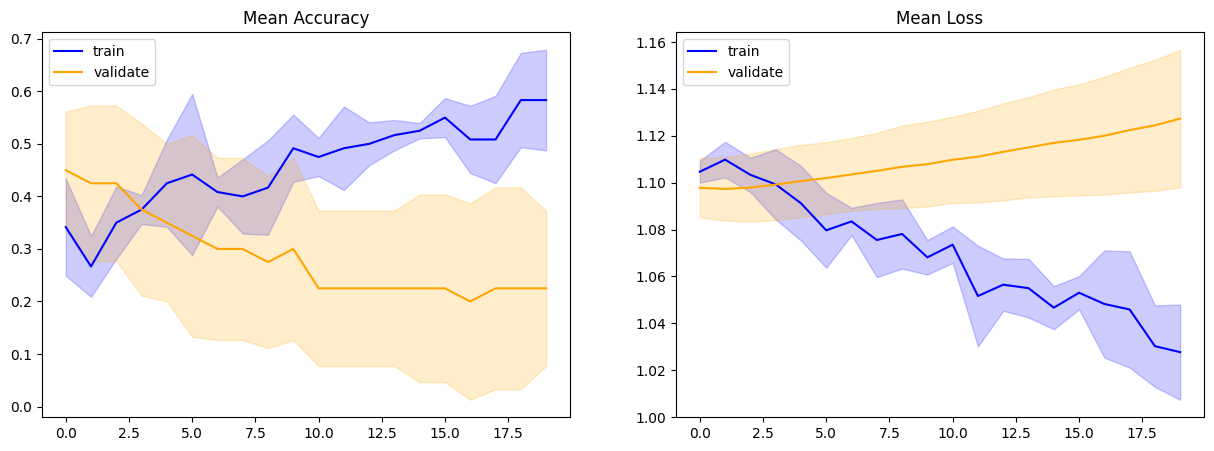

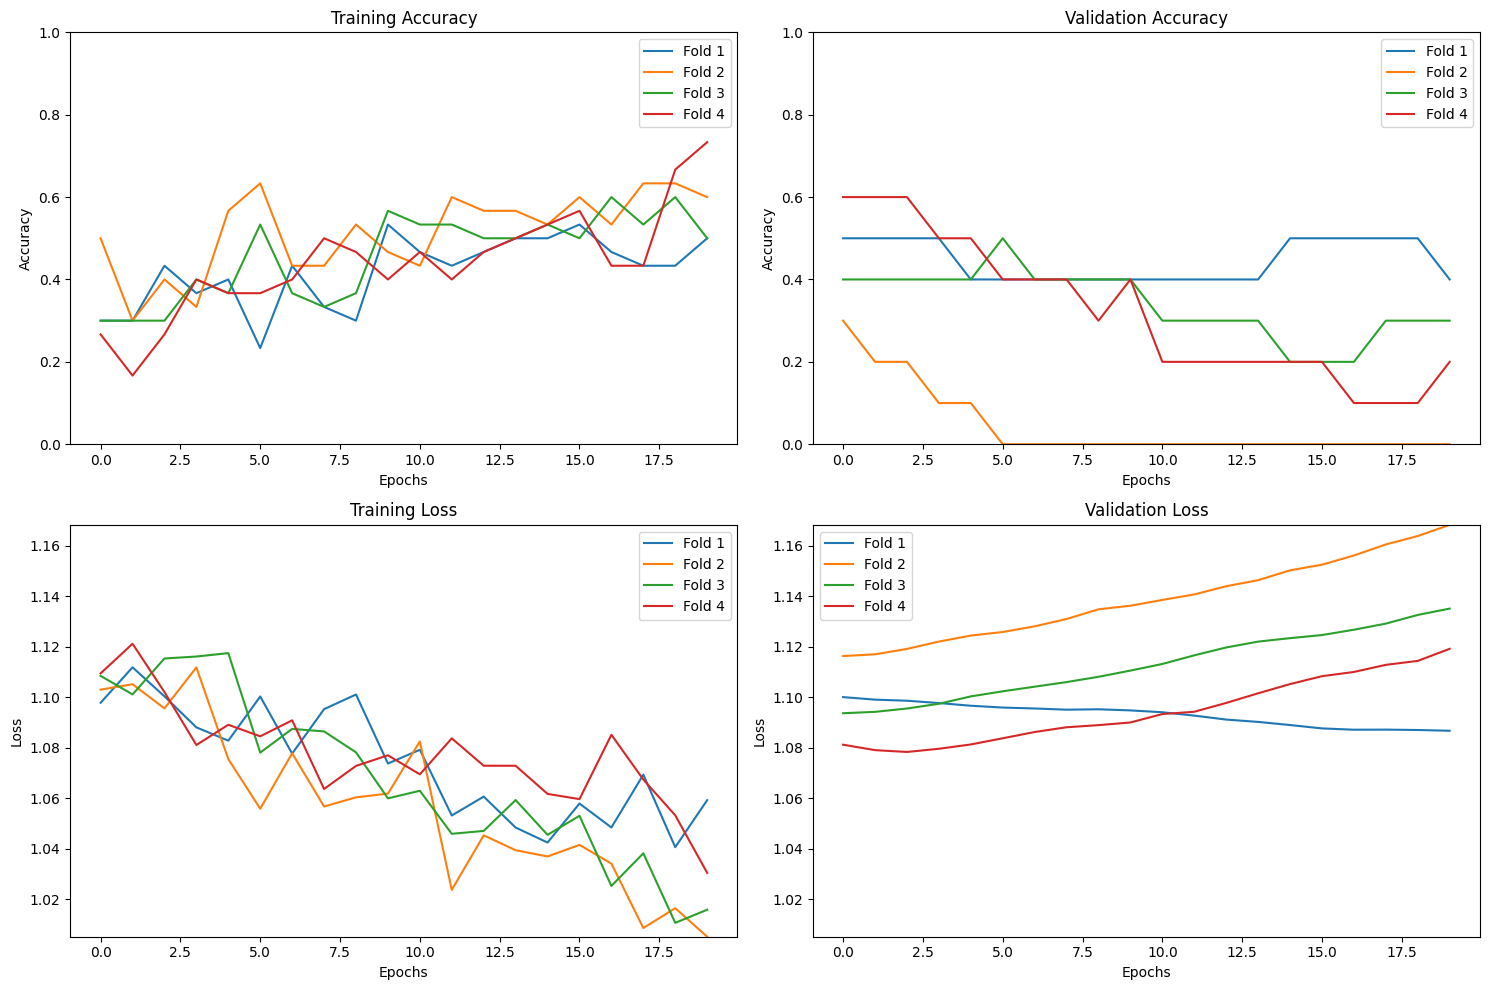

In [71]:
def crossvalidate(train_val_df, model, predictors, target, kf, es_callback):
    '''function for crossvalidation of the model
    train_val_df - dataframe with train and validate data
    model - model to be trained
    predictors - list of predictors
    target - target variable
    kf - KFold object
    es_callback - EarlyStopping callback
    '''

    
    i=1

    acc_scores = []
    loss_scores = []

    acc_histories = []
    loss_histories = []
    val_acc_histories = []
    val_loss_histories = []

    global_confidence_scores = []


    for train_index, validate_index in kf.split(train_val_df):
        # reset weights
        reset_weights(model)
        
        train_df = train_val_df.iloc[train_index]
        validate_df = train_val_df.iloc[validate_index]

        # create train and validate datasets 
        X_train = train_df[predictors].values
        y_train = train_df[target].values
        y_train = keras.utils.to_categorical(y_train)

        X_validate = validate_df[predictors].values
        y_validate = validate_df[target].values
        y_validate = keras.utils.to_categorical(y_validate)

        # fit the model
        print(f"training for {i} subset")
        history = model.fit(X_train, y_train, epochs=100, batch_size=5, validation_data=(X_validate, y_validate), verbose=0, callbacks=[es_callback])
        # evaluate the model

        ev_results = model.evaluate(X_validate, y_validate)



        #save evaluation results 
        acc_scores.append(ev_results[1])
        loss_scores.append(ev_results[0])

        acc_histories.append(history.history['accuracy'])
        loss_histories.append(history.history['loss'])
        val_acc_histories.append(history.history['val_accuracy'])
        val_loss_histories.append(history.history['val_loss'])

        # prediction of the results 
        y_pred = model.predict(X_validate)
        y_pred_class = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_validate, axis=1)
        print(f"predicted classes:       {y_pred_class}")
        print(f"true validation classes: {y_true}")

        # confidence scores 

        confidence_scores = []
        for row in y_pred:
            highest = np.max(row)
            mean = np.mean(np.delete(row, np.argmax(row)))
            confidence_score = round(((highest / mean)-1),4)
            confidence_scores.append(confidence_score)
            global_confidence_scores.append(confidence_score)
        
        mean_confidence = np.mean(confidence_scores)
        sd_confidence = np.std(confidence_scores)

        print(f"mean confidence score: {round(mean_confidence,4)}, sd confidence score: {round(sd_confidence,4)}")
        print("=====================================================")

        



        i+=1

    # calculate mean scores

    mean_acc_score = np.mean(acc_scores)
    sd_acc_score = np.std(acc_scores)
    mean_loss_score = np.mean(loss_scores)
    sd_loss_score = np.std(loss_scores)


    # part to plot mean values from history

    # padding vecors with NaNs to the same length
    max_length = max(len(vec) for vec in acc_histories) 
    padded_results_acc = np.array([np.pad(vec, (0, max_length - len(vec)), mode='constant', constant_values=np.nan) for vec in acc_histories])
    padded_results_val_acc = np.array([np.pad(vec, (0, max_length - len(vec)), mode='constant', constant_values=np.nan) for vec in val_acc_histories])
    padded_results_loss = np.array([np.pad(vec, (0, max_length - len(vec)), mode='constant', constant_values=np.nan) for vec in loss_histories])
    padded_results_val_loss = np.array([np.pad(vec, (0, max_length - len(vec)), mode='constant', constant_values=np.nan) for vec in val_loss_histories])


    # mean and sd values for learning curves 
    mean_acc_histories = np.nanmean(padded_results_acc, axis=0)
    sd_acc_histories = np.nanstd(padded_results_acc, axis=0)
    mean_val_acc_histories = np.nanmean(padded_results_val_acc, axis=0)
    sd_val_acc_histories = np.nanstd(padded_results_val_acc, axis=0)
    mean_loss_histories = np.nanmean(padded_results_loss, axis=0)
    sd_loss_histories = np.nanstd(padded_results_loss, axis=0)
    mean_val_loss_histories = np.nanmean(padded_results_val_loss, axis=0)
    sd_val_loss_histories = np.nanstd(padded_results_val_loss, axis=0)
    

    print(f"validation set mean accuracy: {round(mean_acc_score,4)}, sd{round(sd_acc_score,4)}, mean loss: {round(mean_loss_score,4)}, sd: {round(sd_loss_score,4)}")
    print(f"global mean confidence score: {round(np.mean(global_confidence_scores),4)}, sd confidence score: {round(np.std(global_confidence_scores),4)}")
    # plotting mean curves 

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(mean_acc_histories, label='train', color='blue')
    plt.fill_between(range(len(mean_acc_histories)), mean_acc_histories - sd_acc_histories, mean_acc_histories + sd_acc_histories, color='blue', alpha=0.2)
    plt.plot(mean_val_acc_histories, label='validate', color='orange')
    plt.fill_between(range(len(mean_val_acc_histories)), mean_val_acc_histories - sd_val_acc_histories, mean_val_acc_histories + sd_val_acc_histories, color='orange', alpha=0.2)
    plt.legend()
    plt.title("Mean Accuracy")

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(mean_loss_histories, label='train', color='blue')
    plt.fill_between(range(len(mean_loss_histories)), mean_loss_histories - sd_loss_histories, mean_loss_histories + sd_loss_histories, color='blue', alpha=0.2)
    plt.plot(mean_val_loss_histories, label='validate', color='orange')
    plt.fill_between(range(len(mean_val_loss_histories)), mean_val_loss_histories - sd_val_loss_histories, mean_val_loss_histories + sd_val_loss_histories, color='orange', alpha=0.2)
    plt.legend()
    plt.title("Mean Loss")

    plt.show()


    # calculating min and max values for loss plots range 
    flat_loss_histories = np.concatenate(loss_histories)
    flat_val_loss_histories = np.concatenate(val_loss_histories)
    min_loss = min((min(flat_loss_histories), min(flat_val_loss_histories)))
    max_loss = max((max(flat_loss_histories), max(flat_val_loss_histories)))



    # Plotting results for each fold 
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))


    # Accuracy
    for i, acc in enumerate(acc_histories):
        axs[0, 0].plot(acc, label=f'Fold {i+1}')
    axs[0, 0].set_title('Training Accuracy')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    axs[0, 0].legend()

    # Validation Accuracy
    for i, val_acc in enumerate(val_acc_histories):
        axs[0, 1].plot(val_acc, label=f'Fold {i+1}')
    axs[0, 1].set_title('Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    axs[0, 1].legend()

    # Loss
    for i, loss in enumerate(loss_histories):
        axs[1, 0].plot(loss, label=f'Fold {i+1}')
    axs[1, 0].set_title('Training Loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].set_ylim(min_loss,max_loss)  # Set y-axis scale based on the maximum loss value
    axs[1, 0].legend()

    # Validation Loss
    for i, val_loss in enumerate(val_loss_histories):
        axs[1, 1].plot(val_loss, label=f'Fold {i+1}')
    axs[1, 1].set_title('Validation Loss')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].set_ylim(min_loss,max_loss)  # Set y-axis scale based on the maximum validation loss value
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


crossvalidate(train_val_df, model2, predictors, 'pond', kf, es_callback)

After crossvalidation we can note that the results are bad, we can see overfitting problem happening with since very beggining of training, epoch 5 or so. And thus early stopping callback is halting learning process. 
Lets now train model on whole training dataset and see results for test dataset.

(40, 227) (40, 3) (10, 227) (10, 3)
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3000 - loss: 1.1231
[1.123064637184143, 0.30000001192092896]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [1 1 1 1 0 1 0 1 1 1]
True values: [2 1 2 0 2 1 1 1 0 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.32888034 0.34026882 0.33085078]
 [0.315117   0.342924   0.34195906]
 [0.32687613 0.36518234 0.30794147]
 [0.29397085 0.4139511  0.29207805]
 [0.34002766 0.33305904 0.3269133 ]
 [0.32550353 0.34422535 0.33027112]
 [0.35926408 0.30806234 0.3326735 ]
 [0.3258786  0.34140268 0.33271876]
 [0.33261624 0.33801582 0.3293679 ]
 [0.33009052 0.34191573 0.32799378]]
[1 1 1 1 0 1 0 1 1 1]
[2 1 2 0 2 1 1 1 0 2]
[0.0315, 0.0438, 0.1505, 0.4127, 0.0304, 0.0498, 0.1214, 0.0368, 0.0212, 0.0391]


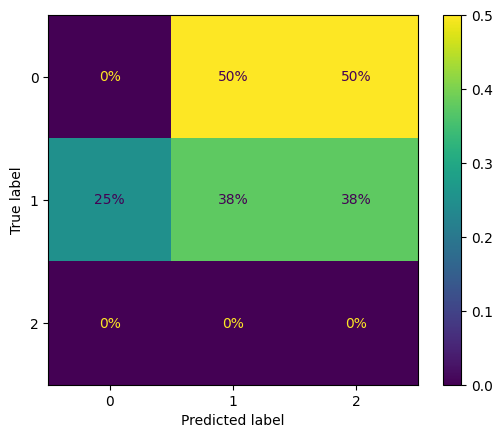

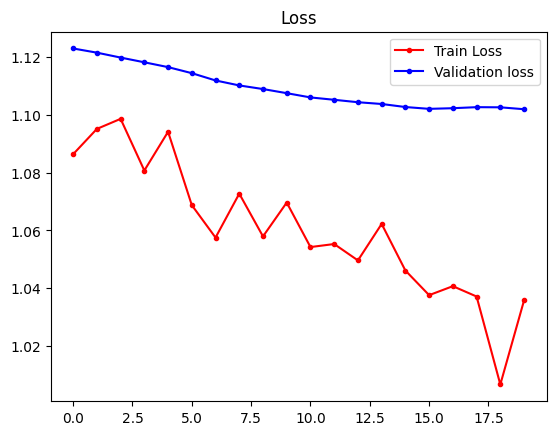

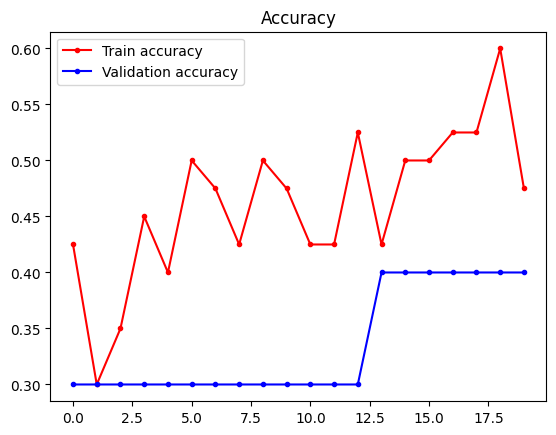

In [58]:
reset_weights(model2)
X_train = train_val_df[predictors].values
y_train = train_val_df['pond'].values
y_train = keras.utils.to_categorical(y_train)

X_test = test_df[predictors].values
y_test = test_df['pond'].values
y_test = keras.utils.to_categorical(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

history = model2.fit(X_train, y_train, epochs=100, batch_size=5, verbose=0, callbacks=[es_callback], validation_data=(X_test, y_test))

evaluate_model(model2,history, X_test, y_test)


y_pred = model2.predict(test_df[predictors].values)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_df['pond'].values

confidence_scores = []
for row in y_pred:
    highest = np.max(row)
    mean = np.mean(np.delete(row, np.argmax(row)))
    confidence_score = round(((highest / mean)-1),4)
    confidence_scores.append(confidence_score)
    
print(f"mean of confidence scores:{np.mean(confidence_scores)}, sd:{np.std(confidence_scores)}")


Here we can see that accuracy is bit better, although we have to note that as we have only 3 classes and underrepresentation of class 0, by assigning all og our observation to class 1 we would end up with accuracy of 20/50 so 40%, and that's what's mostly happening in end model, loss curve for validation is showing overfitting.Judging from confidence score model is not quite sure of its decisions. Model confusion can also be caused by mixing two timepoints. From biological perspective there should be differences between them which we are not taking into account.  Lets fix that.


### Modeling class differences in second timepoint

In this section we will classify based on differences in between enviromental supplementation in second timepoint only. biologicaly there should be more differences on this timepoint as enviroment had timne to react to supplementation.

In [59]:
df_second_tp = train_val_df[train_val_df["class_timepoint"]==1]
print(df_second_tp.shape)
df_second_tp.head()

(20, 230)


,pond,pondXtime,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
37,1,1_1,1,0.230978,0.140625,0.178609,0.429412,0.174757,0.000000,0.044248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,1,1_1,1,0.078804,0.269531,0.019494,0.229412,0.300971,0.000000,0.123894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2,2_1,1,0.380435,0.441406,0.197050,0.394118,0.029126,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,1,1_1,1,0.225543,0.324219,0.156481,0.811765,0.058252,0.000000,0.115044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2,2_1,1,0.035326,0.375000,0.006849,0.076471,0.000000,0.023256,0.327434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
X=df_second_tp[predictors].values
y=df_second_tp["class_pond"].values
yt = keras.utils.to_categorical(y, 3)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(15, 227) (10, 227) (15, 3) (10, 3)


In [69]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
#model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(3, activation ='softmax'))

model3.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,531 (150.51 KB)

 Trainable params: 38,531 (150.51 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6000 - loss: 1.0582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
predicted classes:       [1 0 0 2 0]
true validation classes: [1 2 0 2 1]
mean confidence score: 0.1699, sd confidence score: 0.0929
training for 2 subset
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 33.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4000 - loss: 0.9788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [1 1 1 1 1]
true validation classes: [1 2 1 0 0]
mean confidence score: 0.4419, sd confidence score: 0.2903
training for 3 subset
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6000 - loss: 1.0957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted classes:       [1 0 1 0 0]
true validation classes: [1 2 1 2 0]
mean confi

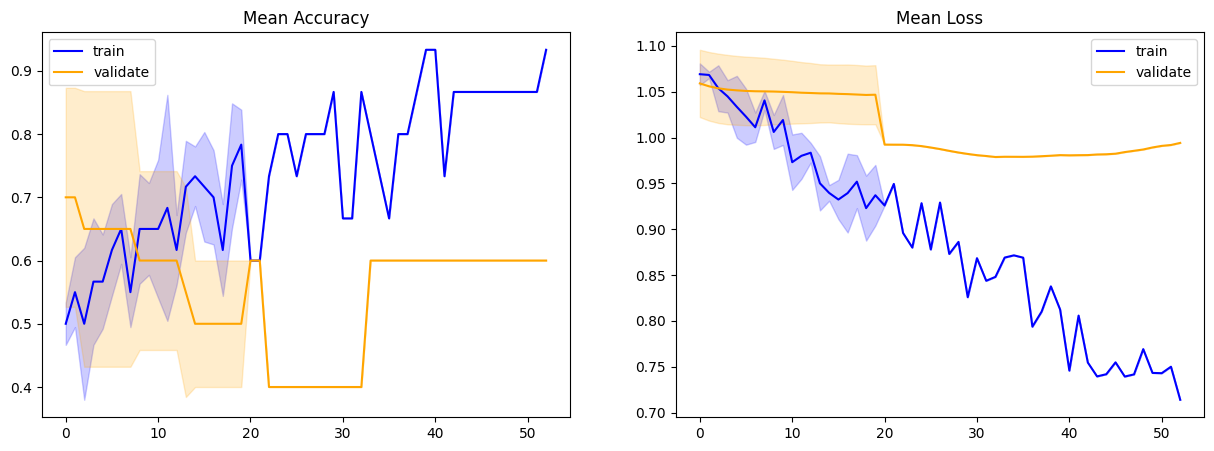

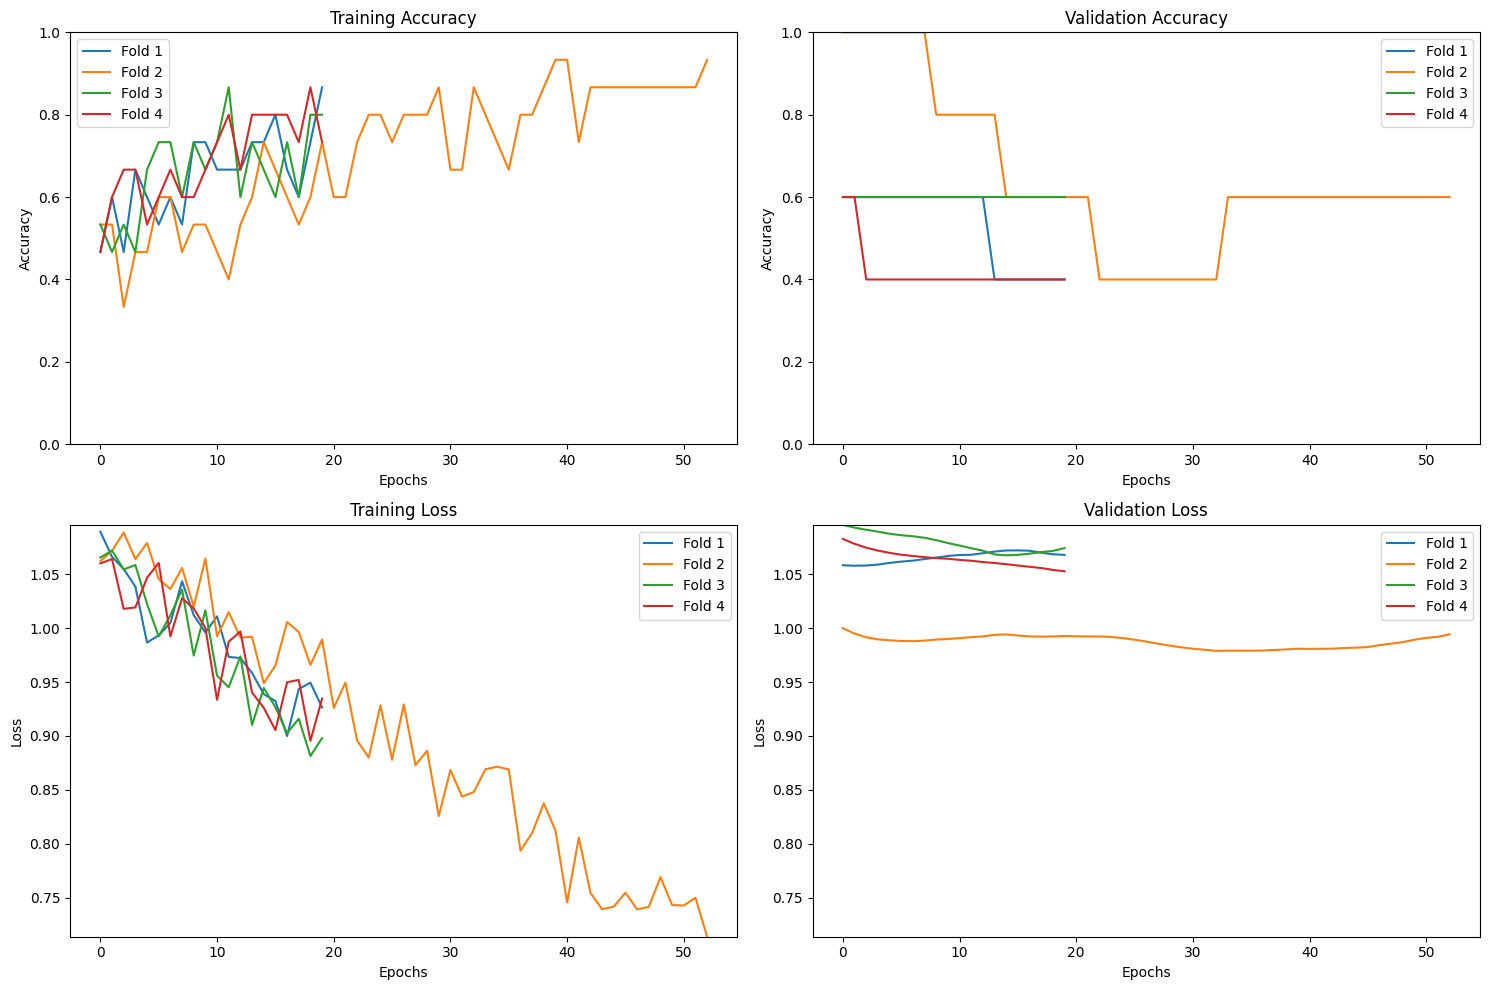

In [70]:
crossvalidate(df_second_tp, model3, predictors, 'pond', kf, es_callback)

In [67]:
history3=model3.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4667 - loss: 1.0856 - val_accuracy: 0.4000 - val_loss: 1.0929
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3333 - loss: 1.1680 - val_accuracy: 0.4000 - val_loss: 1.0928
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3333 - loss: 1.1259 - val_accuracy: 0.5000 - val_loss: 1.0929
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4667 - loss: 1.0745 - val_accuracy: 0.5000 - val_loss: 1.0930
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2667 - loss: 1.0812 - val_accuracy: 0.5000 - val_loss: 1.0928
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4000 - loss: 1.1107 - val_accuracy: 0.5000 - val_loss: 1.0928
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2000 - loss: 1.1202 - val_accuracy: 0.5000 - val_loss: 1.0928
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4667 - loss: 1.1071 - val_accuracy: 0.5000 - val_loss: 1.0927
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5000 - loss: 1.2403
[1.2402557134628296, 0.5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted values: [1 1 1 1 1 1 2 1 1 2]
True values: [0 2 2 2 1 1 0 1 1 2]


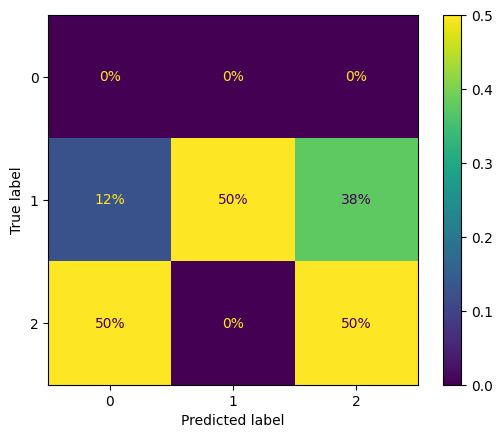

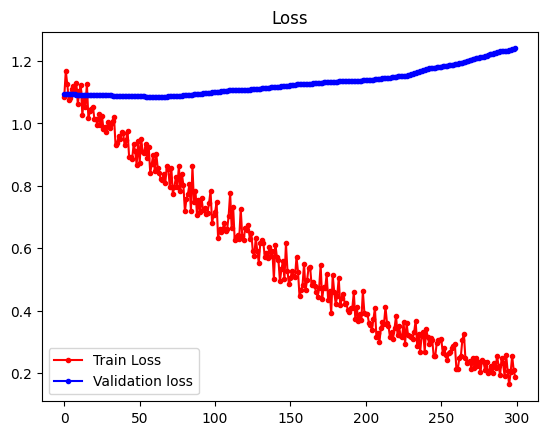

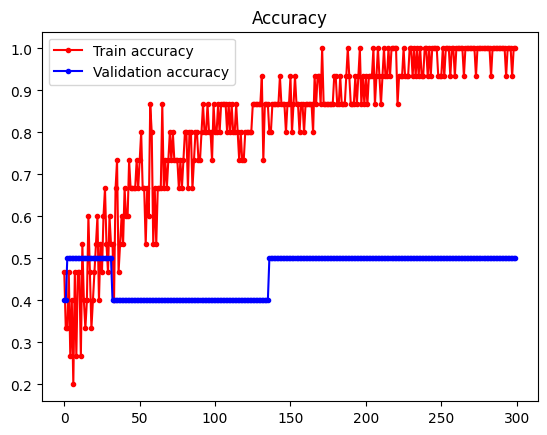

In [68]:
evaluate_model(model3, history3, X_test, y_test)

The results are finally good, There is big overfitting prpoblem caused probably by low (15) sample size for training nevertheless end accuracy of stable 0.8 is promissing. We should now check if the model will baheave the same way for first timepoint, with lower if any differences between classes. 

### Modeling class differences in first timepoint

In this section we will atempt to classify based on first timepoint data, untill this time bad classification results on both timepoints suggest that there are differences between timepoints, we had good classsification on second timepoint so we can note that there are differences between classes. Now we haave to check if there are any differences on first timepoint.

In [50]:
df_first_tp = df_norm[df_norm["class_timepoint"]==0]
print(df_first_tp.shape)
df_second_tp.head()

(25, 231)


,pond,timepoint,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
1,Sed_S10,1,1,0.048913,0.585938,0.005269,0.758824,0.000000,0.000000,0.265487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Sed_S11,1,1,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,Sed_S12,1,1,0.127717,0.343750,0.012645,0.247059,0.000000,0.023256,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,Sed_S13,1,1,0.380435,0.441406,0.197050,0.394118,0.029126,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,Sed_S14,1,1,0.491848,0.859375,0.131191,0.276471,0.223301,0.488372,0.353982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [51]:
X=df_first_tp[predictors].values
y=df_first_tp["class_pond"].values
yt = keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(15, 227) (10, 227) (15, 2) (10, 2)


In [52]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(2, activation ='softmax'))

model4.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,890 (296.45 KB)

 Trainable params: 75,890 (296.45 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)


In [54]:
history4 = model4.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 0.8515 - val_accuracy: 0.4000 - val_loss: 0.7621
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4000 - loss: 0.8205 - val_accuracy: 0.4000 - val_loss: 0.7576
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4000 - loss: 0.8508 - val_accuracy: 0.4000 - val_loss: 0.7534
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4000 - loss: 0.8040 - val_accuracy: 0.4000 - val_loss: 0.7497
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4000 - loss: 0.8203 - val_accuracy: 0.4000 - val_loss: 0.7462
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3333 - loss: 0.8354 - val_accuracy: 0.4000 - val_loss: 0.7427
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4000 - loss: 0.7717 - val_accuracy: 0.4000 - val_loss: 0.7397
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4000 - loss: 0.7903 - val_accuracy: 0.4000 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3000 - loss: 0.9365
[0.9364503026008606, 0.30000001192092896]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted values: [1 0 0 0 0 0 0 1 1 0]
True values: [0 1 1 1 0 0 0 0 0 1]


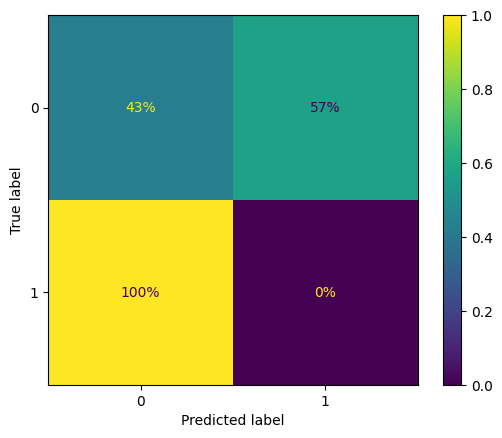

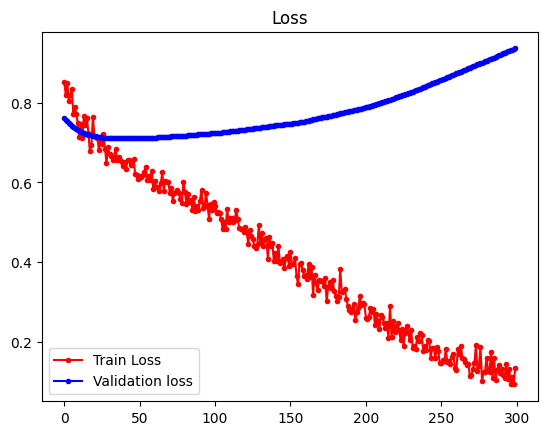

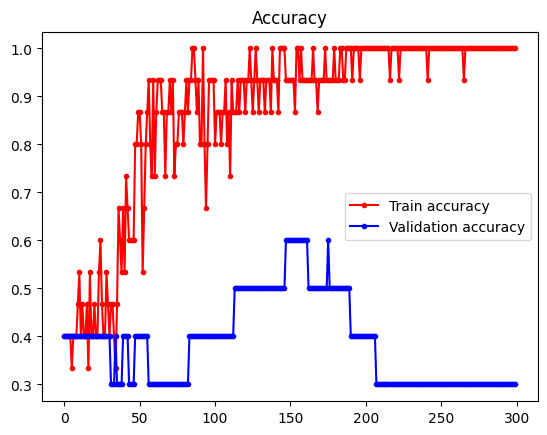

In [57]:
evaluate_model(model4, history4, X_test, y_test)

In [29]:
df["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
df_norm["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)

C:\Users\marek\AppData\Local\Temp\ipykernel_12108\1246733335.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)


In [30]:
len(df["class_timepoint*pond"].unique())

10

In [31]:
X=df[predictors].values
y=df["class_timepoint*pond"].values
y = LabelEncoder().fit_transform(y)
y
yt = keras.utils.to_categorical(y, 10)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(40, 227) (10, 227) (40, 10) (10, 10)


In [35]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(10, activation ='softmax'))

model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,026 (296.98 KB)

 Trainable params: 76,026 (296.98 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [39]:
history4=model4.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2667 - loss: 4.1243 - val_accuracy: 0.2000 - val_loss: 4.2980
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2708 - loss: 3.2869 - val_accuracy: 0.2000 - val_loss: 4.2802
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3542 - loss: 4.1701 - val_accuracy: 0.2000 - val_loss: 4.2684
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2292 - loss: 4.9528 - val_accuracy: 0.2000 - val_loss: 4.2440
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2333 - loss: 4.1106 - val_accuracy: 0.2000 - val_loss: 4.2116
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3208 - loss: 4.8887 - val_accuracy: 0.2000 - val_loss: 4.1873
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3417 - loss: 3.4968 - val_accuracy: 0.2000 - val_loss: 4.1748
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2938 - loss: 3.2503 - val_accuracy: 0.2000 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1000 - loss: 4.1775
[4.177490711212158, 0.10000000149011612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [2 6 0 3 6 6 8 6 8 8]
True values: [6 2 9 0 7 5 4 3 1 8]


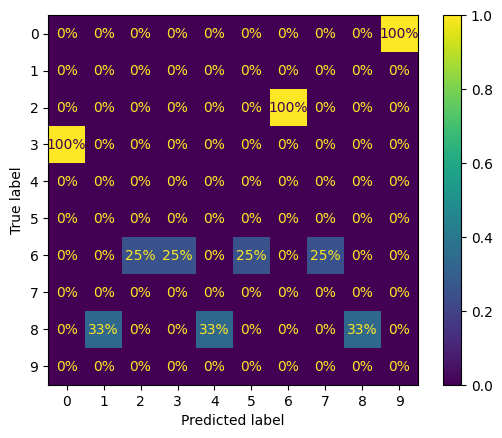

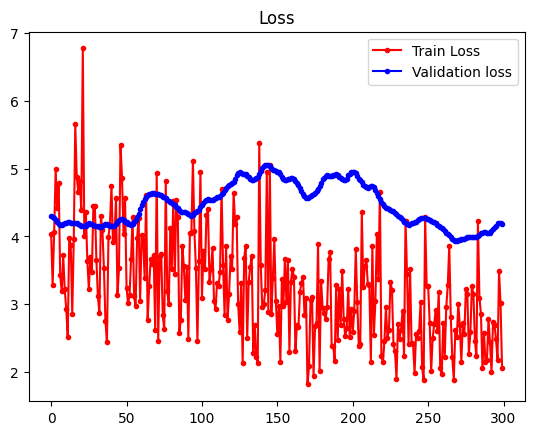

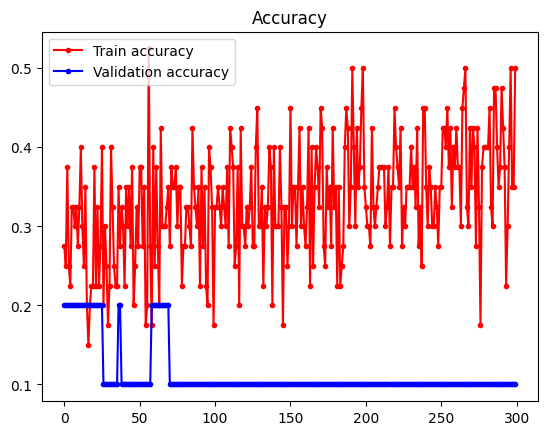

In [40]:
evaluate_model(model4, history4, X_test, y_test)

Although we dont see signs of overfitting accuracy is lackluster either, close to random. We will now reuse 2 class classification approach from gut dataset. This time we will use enviromental.
supplementation as class. This will be in next notebook Sediment_2.ipynb

,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond,class_timepoint*pond
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0_2
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1_2
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0_4
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1_4
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0_1
5,Sed_S12,1,47.0,88.0,24.0,42.0,0.0,2.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1_1
6,Sed_S13,0,64.0,185.0,0.0,74.0,11.0,19.0,60.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0_3
7,Sed_S13,1,140.0,113.0,374.0,67.0,3.0,86.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1_3
8,Sed_S14,0,35.0,69.0,15.0,3.0,0.0,0.0,41.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0_0
9,Sed_S14,1,181.0,220.0,249.0,47.0,23.0,42.0,40.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1_0
